##### Copyright 2020 The TensorFlow Authors.

In [586]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

Based on https://www.tensorflow.org/quantum/tutorials/mnist

We build a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [587]:
#!pip3 install -q tensorflow==2.3.1
!python3.8 -m pip install -q tensorflow==2.4.1
!python3.8 -m pip install tensorboard_plugin_profile==2.3.0
%load_ext tensorboard

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfq-nightly 0.5.0.dev20210516 requires grpcio==1.30.0, but you have grpcio 1.32.0 which is incompatible.
You should consider upgrading via the '/mnt/c/Users/mmints/Documents/Stanford/CS230/project/CS230_quantum_dropout/qenv_project/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/mnt/c/Users/mmints/Documents/Stanford/CS230/project/CS230_quantum_dropout/qenv_project/bin/python3.8 -m pip install --upgrade pip' command.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Install TensorFlow Quantum:

In [588]:
#!pip3 install -q tensorflow-quantum
!python3.8 -m pip install tfq-nightly

  Using cached grpcio-1.30.0-cp38-cp38-manylinux2010_x86_64.whl (3.0 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.30.0 which is incompatible.
You should consider upgrading via the '/mnt/c/Users/mmints/Documents/Stanford/CS230/project/CS230_quantum_dropout/qenv_project/bin/python3.8 -m pip install --upgrade pip' command.


Now import TensorFlow and the module dependencies:

In [602]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import datetime
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# set the random seed
tf.random.set_seed(137)
np.random.seed(137)



NUM_EXAMPLES = 500

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [603]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for `6`. 

In [604]:
def filter_365(x, y):
    keep = (y == 3) | (y == 6) | (y == 5)
    x, y = x[keep], y[keep]
    y_res = y == 3
    return x,y_res,y

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [605]:
x_train, y_train, y_train_origval = filter_365(x_train, y_train) # add some 9-s to the training set so we can overfit
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

# We do a lot of computation so we want to limit the number of examples ASAP
x_train = x_train[:NUM_EXAMPLES]
y_train = y_train[:NUM_EXAMPLES]
y_train_origval = y_train_origval[:NUM_EXAMPLES]

print("After restricting - number of filtered training examples:", len(x_train))
print("After restricting - number of filtered test examples:", len(x_test))

print("Number of 3 values: ", np.count_nonzero(y_train_origval == 3))
print("Number of 6 values: ", np.count_nonzero(y_train_origval == 6))
print("Number of 5 values: ", np.count_nonzero(y_train_origval == 5))

Number of filtered training examples: 17470
Number of filtered test examples: 1968
After restricting - number of filtered training examples: 500
After restricting - number of filtered test examples: 1968
Number of 3 values:  169
Number of 6 values:  174
Number of 5 values:  157


shape of x_train is (500, 28, 28, 1)
type of x_train is <class 'numpy.ndarray'>
shape of x_test is (1968, 28, 28, 1)
type of x_test is <class 'numpy.ndarray'>
shape of x_train_deskew is (500, 28, 28, 1)
type of x_train_deskew is <class 'numpy.ndarray'>
shape of x_test_deskew is (1968, 28, 28, 1)
type of x_test_deskew is <class 'numpy.ndarray'>


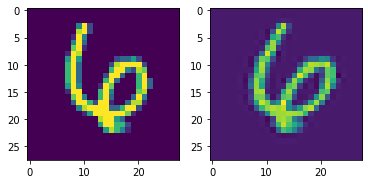

In [606]:
# The following moment and deskew functions were taken from the works of :

# https://stackoverflow.com/questions/43577665/deskew-mnist-images
# https://fsix.github.io/mnist/Deskewing.html

from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix
#Deskew the training samples 
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())
#examples = (4181, 0), (3,1), (56282, 2), (25829,3), (9741,4) , (26901,5), (50027,6), (17935,7) , (41495, 8), (14662, 9)
#
#from mpl_toolkits.axes_grid1 import AxesGrid
#grid = AxesGrid(plt.figure(figsize=(8,15)), 141,  # similar to subplot(141)
#                    nrows_ncols=(10, 2),
#                    axes_pad=0.05,
#                    label_mode="1",
#                    )
#
#for examplenum,num in examples:
#    im = grid[2*num].imshow(x_train[examplenum].reshape(28,28))
#    im2 = grid[2*num+1].imshow(deskew(x_train[examplenum].reshape(28,28)))
#plt.subplot(1, 2, 1)
#plt.imshow(x_train[3].reshape(28,28))
#
#newim = deskew(x_train[3].reshape(28,28))
#plt.subplot(1, 2, 2)
#plt.imshow(newim)

print("shape of x_train is " + str(x_train.shape))
print("type of x_train is " + str(type(x_train)))
print("shape of x_test is " + str(x_test.shape))
print("type of x_test is " + str(type(x_test)))


#store the deskwed x_train into a list x_test_deskew
#store the deskwed x_test into a list x_test_deskew

#training set 
x_train_deskew = [] 
for i in range(x_train.shape[0]): 
    x_train_deskew.append(deskew(x_train[i].reshape(28,28)))
x_train_deskew = np.array(x_train_deskew)
x_train_deskew = x_train_deskew[..., np.newaxis]
print("shape of x_train_deskew is " + str(np.shape(x_train_deskew)))
print("type of x_train_deskew is " + str(type(x_train_deskew)))

#test set 
x_test_deskew = [] 
for j in range(x_test.shape[0]): 
    x_test_deskew.append(deskew(x_test[j].reshape(28,28)))
x_test_deskew = np.array(x_test_deskew)
x_test_deskew = x_test_deskew[..., np.newaxis]
print("shape of x_test_deskew is " + str(np.shape(x_test_deskew)))
print("type of x_test_deskew is " + str(type(x_test_deskew)))


#We should have the deskewed image stored within x_train
#original 
plt.subplot(1, 2, 1)
plt.imshow(x_train[3].reshape(28,28))

#deskewed 
plt.subplot(1, 2, 2)
plt.imshow(x_train_deskew[3])


#We should have the deskewed image stored within x_test 
#original
plt.subplot(1, 2, 1)
plt.imshow(x_test[3].reshape(28,28))

#deskewed
plt.subplot(1, 2, 2)
plt.imshow(x_test_deskew[3])

Show the first example:

False


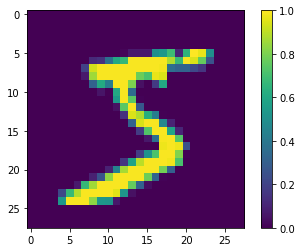

In [607]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [608]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

# 16x16 for amplitude embedding!
x_train_small_256 = tf.image.resize(x_train, (16,16)).numpy()
x_test_small_256 = tf.image.resize(x_test, (16,16)).numpy()

Again, display the first training example—after resize: 

False


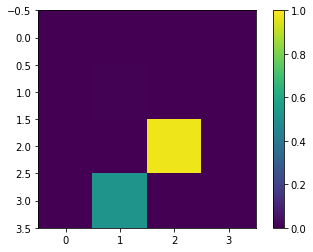

In [609]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

False


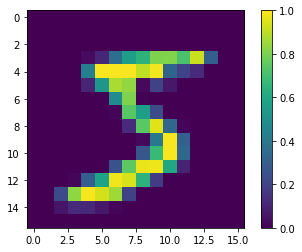

In [610]:
print(y_train[0])

plt.imshow(x_train_small_256[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [611]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [612]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 475
Number of unique 3s:  152
Number of unique 6s:  321
Number of unique contradicting labels (both 3 and 6):  2

Initial number of images:  500
Remaining non-contradicting unique images:  473


In [613]:
#x_train_nocon_256, y_train_nocon_256 = remove_contradicting(x_train_small_256, y_train)

# removing contradictory images is not an issue for 16x16 images!

In [614]:
# Duplicate some entries to illustrate the effects of dropout! Run this cell only if testing dropout
NUM_DUPLICATE = 200

for i in range(NUM_DUPLICATE):
    x_train_nocon = np.insert(x_train_nocon, 0, x_train_nocon[0], axis=0)
    y_train_nocon = np.insert(y_train_nocon, 0, y_train_nocon[0], axis=0)
print(x_train_nocon.shape)
print(y_train_nocon.shape)

(673, 4, 4, 1)
(673,)


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [615]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [616]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 68
Number of unique 3s:  15
Number of unique 6s:  36
Number of unique contradicting labels (both 3 and 6):  17

Initial number of images:  673
Remaining non-contradicting unique images:  51


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [617]:
# tolerance for normalization
TOLERANCE = 1e-10

# Use Mottonen state preparation to get an amplitude embedding of the states
# Adapted from https://pennylane.readthedocs.io/en/stable/_modules/pennylane/templates/state_preparations/mottonen.html#MottonenStatePreparation

def gray_code(rank):
    """Generates the Gray code of given rank.

    Args:
        rank (int): rank of the Gray code (i.e. number of bits)
    """

    def gray_code_recurse(g, rank):
        k = len(g)
        if rank <= 0:
            return

        for i in range(k - 1, -1, -1):
            char = "1" + g[i]
            g.append(char)
        for i in range(k - 1, -1, -1):
            g[i] = "0" + g[i]

        gray_code_recurse(g, rank - 1)

    g = ["0", "1"]
    gray_code_recurse(g, rank - 1)

    return g


def _matrix_M_entry(row, col):
    """Returns one entry for the matrix that maps alpha to theta.

    See Eq. (3) in `Möttönen et al. (2004) <https://arxiv.org/pdf/quant-ph/0407010.pdf>`_.

    Args:
        row (int): one-based row number
        col (int): one-based column number

    Returns:
        (float): transformation matrix entry at given row and column
    """
    # (col >> 1) ^ col is the Gray code of col
    b_and_g = row & ((col >> 1) ^ col)
    sum_of_ones = 0
    while b_and_g > 0:
        if b_and_g & 0b1:
            sum_of_ones += 1

        b_and_g = b_and_g >> 1

    return (-1) ** sum_of_ones


def _compute_theta(alpha):
    """Maps the angles alpha of the multi-controlled rotations decomposition of a uniformly controlled rotation
     to the rotation angles used in the Gray code implementation.

    Args:
        alpha (tensor_like): alpha parameters

    Returns:
        (tensor_like): rotation angles theta
    """
    ln = alpha.shape[0]
    k = np.log2(alpha.shape[0])

    M_trans = np.zeros(shape=(ln, ln))
    for i in range(len(M_trans)):
        for j in range(len(M_trans[0])):
            M_trans[i, j] = _matrix_M_entry(j, i)

    theta = np.dot(M_trans, alpha)

    return theta / 2 ** k


def _uniform_rotation_dagger(gate, alpha, control_wires, target_wire, circuit):
    r"""Applies a uniformly-controlled rotation to the target qubit.

    A uniformly-controlled rotation is a sequence of multi-controlled
    rotations, each of which is conditioned on the control qubits being in a different state.
    For example, a uniformly-controlled rotation with two control qubits describes a sequence of
    four multi-controlled rotations, each applying the rotation only if the control qubits
    are in states :math:`|00\rangle`, :math:`|01\rangle`, :math:`|10\rangle`, and :math:`|11\rangle`, respectively.

    To implement a uniformly-controlled rotation using single qubit rotations and CNOT gates,
    a decomposition based on Gray codes is used. For this purpose, the multi-controlled rotation
    angles alpha have to be converted into a set of non-controlled rotation angles theta.

    For more details, see `Möttönen and Vartiainen (2005), Fig 7a<https://arxiv.org/pdf/quant-ph/0504100.pdf>`_.

    Args:
        gate (.Operation): gate to be applied, needs to have exactly one parameter
        alpha (tensor_like): angles to decompose the uniformly-controlled rotation into multi-controlled rotations
        control_wires (array[int]): wires that act as control
        target_wire (int): wire that acts as target
    """

    theta = _compute_theta(alpha)

    gray_code_rank = len(control_wires)

    if gray_code_rank == 0:
        if theta[0] != 0.0:
            circuit.append(gate(theta[0])(target_wire))
        return

    code = gray_code(gray_code_rank)
    num_selections = len(code)

    control_indices = [
        int(np.log2(int(code[i], 2) ^ int(code[(i + 1) % num_selections], 2)))
        for i in range(num_selections)
    ]

    for i, control_index in enumerate(control_indices):
        if theta[i] != 0.0:
            circuit.append(gate(theta[i])(target_wire))
        circuit.append(cirq.CNOT(control_wires[control_index], target_wire))


def _get_alpha_z(omega, n, k):
    r"""Computes the rotation angles required to implement the uniformly-controlled Z rotation
    applied to the :math:`k`th qubit.

    The :math:`j`th angle is related to the phases omega of the desired amplitudes via:

    .. math:: \alpha^{z,k}_j = \sum_{l=1}^{2^{k-1}} \frac{\omega_{(2j-1) 2^{k-1}+l} - \omega_{(2j-2) 2^{k-1}+l}}{2^{k-1}}

    Args:
        omega (tensor_like): phases of the state to prepare
        n (int): total number of qubits for the uniformly-controlled rotation
        k (int): index of current qubit

    Returns:
        array representing :math:`\alpha^{z,k}`
    """
    indices1 = [
        [(2 * j - 1) * 2 ** (k - 1) + l - 1 for l in range(1, 2 ** (k - 1) + 1)]
        for j in range(1, 2 ** (n - k) + 1)
    ]
    indices2 = [
        [(2 * j - 2) * 2 ** (k - 1) + l - 1 for l in range(1, 2 ** (k - 1) + 1)]
        for j in range(1, 2 ** (n - k) + 1)
    ]

    term1 = np.take(omega, indices=indices1)
    term2 = np.take(omega, indices=indices2)
    diff = (term1 - term2) / 2 ** (k - 1)

    return np.sum(diff, axis=1)


def _get_alpha_y(a, n, k):
    r"""Computes the rotation angles required to implement the uniformly controlled Y rotation
    applied to the :math:`k`th qubit.

    The :math:`j`-th angle is related to the absolute values, a, of the desired amplitudes via:

    .. math:: \alpha^{y,k}_j = 2 \arcsin \sqrt{ \frac{ \sum_{l=1}^{2^{k-1}} a_{(2j-1)2^{k-1} +l}^2  }{ \sum_{l=1}^{2^{k}} a_{(j-1)2^{k} +l}^2  } }

    Args:
        a (tensor_like): absolute values of the state to prepare
        n (int): total number of qubits for the uniformly-controlled rotation
        k (int): index of current qubit

    Returns:
        array representing :math:`\alpha^{y,k}`
    """
    indices_numerator = [
        [(2 * (j + 1) - 1) * 2 ** (k - 1) + l for l in range(2 ** (k - 1))]
        for j in range(2 ** (n - k))
    ]
    numerator = np.take(a, indices=indices_numerator)
    numerator = np.sum(np.abs(numerator) ** 2, axis=1)

    indices_denominator = [[j * 2 ** k + l for l in range(2 ** k)] for j in range(2 ** (n - k))]
    denominator = np.take(a, indices=indices_denominator)
    denominator = np.sum(np.abs(denominator) ** 2, axis=1)

    # Divide only where denominator is zero, else leave initial value of zero.
    # The equation guarantees that the numerator is also zero in the corresponding entries.

    with np.errstate(divide="ignore", invalid="ignore"):
        division = numerator / denominator

    division = np.where(denominator != 0.0, division, 0.0)

    return 2 * np.arcsin(np.sqrt(division))

def mottonenStatePrep(state_vector, qubits, circuit):

        a = np.abs(state_vector)
        omega = np.angle(state_vector)

        # change ordering of wires, since original code
        # was written for IBM machines
        wires_reverse = qubits[::-1]

        # Apply inverse y rotation cascade to prepare correct absolute values of amplitudes
        for k in range(len(wires_reverse), 0, -1):
            alpha_y_k = _get_alpha_y(a, len(wires_reverse), k)
            control = wires_reverse[k:]
            target = wires_reverse[k - 1]
            _uniform_rotation_dagger(cirq.ry, alpha_y_k, control, target, circuit)

        # If necessary, apply inverse z rotation cascade to prepare correct phases of amplitudes
        if not np.allclose(omega, 0):
            for k in range(len(wires_reverse), 0, -1):
                alpha_z_k = _get_alpha_z(omega, len(wires_reverse), k)
                control = wires_reverse[k:]
                target = wires_reverse[k - 1]
                if len(alpha_z_k) > 0:
                    _uniform_rotation_dagger(cirq.rz, alpha_z_k, control, target, circuit)

         
# The below is borrowed from https://pennylane.readthedocs.io/en/stable/_modules/pennylane/templates/embeddings/amplitude.html#AmplitudeEmbedding
def _preprocess(features, wires, pad_with, normalize):
    """Validate and pre-process inputs as follows:

    * Check that the features tensor is one-dimensional.
    * If pad_with is None, check that the first dimension of the features tensor
      has length :math:`2^n` where :math:`n` is the number of qubits. Else check that the
      first dimension of the features tensor is not larger than :math:`2^n` and pad features with value if necessary.
    * If normalize is false, check that first dimension of features is normalised to one. Else, normalise the
      features tensor.
    """

    shape = features.shape

    # check shape
    if features.ndim != 1:
        raise ValueError(f"Features must be a one-dimensional tensor; got shape {shape}.")

    n_features = shape[0]
    if pad_with is None and n_features != 2 ** len(wires):
        raise ValueError(
            f"Features must be of length {2 ** len(wires)}; got length {n_features}. "
            f"Use the 'pad' argument for automated padding."
        )

    if pad_with is not None and n_features > 2 ** len(wires):
        raise ValueError(
            f"Features must be of length {2 ** len(wires)} or "
            f"smaller to be padded; got length {n_features}."
        )

    # pad
    if pad_with is not None and n_features < 2 ** len(wires):
        padding = [pad_with] * (2 ** len(wires) - n_features)
        features = np.concatenate([features, padding], axis=0)

    # normalize
    norm = np.sum(np.abs(features) ** 2)

    if not np.allclose(norm, 1.0, atol=TOLERANCE):
        if normalize or pad_with:
            features = features / np.sqrt(norm)
        else:
            raise ValueError(
                f"Features must be a vector of length 1.0; got length {norm}."
                "Use 'normalize=True' to automatically normalize."
            )

    features = features.astype(np.complex128)
    return features

def cirqAppendAmplitudeEmbedding(features, qubits, circuit, pad_with=None, normalize=False):
    features = _preprocess(features, qubits, pad_with, normalize)
    mottonenStatePrep(features, qubits, circuit)

In [618]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    circuit.append(make_qft(qubits))
    return circuit

def convert_to_circuit_mottonen(image):
    values = np.ndarray.flatten(image)
    assert len(values) == 256
    qubits = cirq.GridQubit.rect(4, 2)
    circuit = cirq.Circuit()
    cirqAppendAmplitudeEmbedding(values, qubits, circuit, normalize=True)
    return circuit

#x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
#x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

x_train_circ = [convert_to_circuit_mottonen(x) for x in x_train_nocon_256]
x_test_circ = [convert_to_circuit_mottonen(x) for x in x_test_small_256]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

In [619]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [620]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [621]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

Helper functions for Tensorboard.


- The integer values of samples, so that you can create histograms of the distribution.
- The linear XEB fidelity estimate of a set of samples, to give some indication of how "truly quantum random" the samples are.


In [622]:
@tf.function
def bits_to_ints(bits):
    """Convert tensor of bitstrings to tensor of ints."""
    sigs = tf.constant([1 << i for i in range(N_QUBITS)], dtype=tf.int32)
    rounded_bits = tf.clip_by_value(tf.math.round(
        tf.cast(bits, dtype=tf.dtypes.float32)), clip_value_min=0, clip_value_max=1)
    return tf.einsum('jk,k->j', tf.cast(rounded_bits, dtype=tf.dtypes.int32), sigs)

@tf.function
def xeb_fid(bits):
    """Compute linear XEB fidelity of bitstrings."""
    final_probs = tf.squeeze(
        tf.abs(tfq.layers.State()(REFERENCE_CIRCUIT).to_tensor()) ** 2)
    nums = bits_to_ints(bits)
    return (2 ** N_QUBITS) * tf.reduce_mean(tf.gather(final_probs, nums)) - 1.0


### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [736]:
print(tfq.util.get_supported_gates().keys())
print(tfq.util.get_supported_channels().keys())

class CircuitLayerBuilder():
    def __init__(self, circuit, data_qubits, repeat_dropout=0, overlap_dropout=False):
        
        self.data_qubits = data_qubits
        self.curr_layer_id = 0
        self.circuit = circuit
        
        self.dropped_out_qubit_ids = []
        self.dropout_blacklist = []
        
        self.overlap_dropout = overlap_dropout
        
        if repeat_dropout < 1:
            repeat_dropout = 1
        if overlap_dropout:
            for _ in range(repeat_dropout - 1):
                # We will be dequeing from this on each rebuild;
                # so, each qubit will be in the list for repeat_dropout rebuilds.
                self.dropped_out_qubit_ids.append(len(self.data_qubits))
            self.delay_next_dropout = 1
        else:
            # if not overlapping, delay for as long as we're repeating
            self.delay_next_dropout = repeat_dropout
            
        self.delay_next_dropout_i = 0 # try to dropout immediately
        
        # maps str(symbol) to (is_dropped_out, weight)
        self.symbol_map = {}
        
        self.drop_out_applied = False
        
    def rebuild(self, circuit, data_qubits, computed_weights, preserve_dropout=False):
        # prev_weights is the result of get_weights from the prior epoch.
        
        self.data_qubits = data_qubits
        self.curr_layer_id = 0
        self.circuit = circuit
        
        if preserve_dropout:
            if self.overlap_dropout and len(self.dropped_out_qubit_ids) > 0 and self.drop_out_applied:
                # Dropping first element. This is either padding, or an actual id that we want to stop dropping out from here on.
                dropped_id = self.dropped_out_qubit_ids.pop(0)
                self.dropout_blacklist.append(dropped_id)
        else:
            self.dropout_blacklist = []
            self.dropped_out_qubit_ids = []
        
        if self.delay_next_dropout_i > 0:
            self.delay_next_dropout_i -= 1
        
        if self.delay_next_dropout_i == 0 and not self.overlap_dropout:
            # Dropout finished for this qubit!
            assert len(self.dropped_out_qubit_ids) <= 1
            if len(self.dropped_out_qubit_ids) == 1:
                self.dropout_blacklist.append(self.dropped_out_qubit_ids[0])
            self.dropped_out_qubit_ids = []
        
        self.drop_out_applied = False
        
        #print('self.dropped_out_qubit_ids = ')
        #print(self.dropped_out_qubit_ids)
        
        j = 0
        
        #print('Rebuilding; prev self.symbol_map:')
        #print(self.symbol_map)
        
        for k in sorted(self.symbol_map.keys()):
            prev_is_dropped_out, _ = self.symbol_map[k]
            if not prev_is_dropped_out:
                # Re-use the prev weight. This isn't directly used as TFQ inputs, but we later use it to generate
                # sane inputs for set_weights().
                # Also, is-dropped-out is True by default to handle the case when a rebuilt circuit might not add a layer for some reason
                self.symbol_map[k] = (True, computed_weights[j])

                # prev_weights is a list that only has entries for non-dropped-out elems
                j += 1
                
        #print('Rebuilding done; updated self.symbol_map:')
        #print(self.symbol_map)
    
    def add_param_gate(self, gate, symbol, i, qubit):
        if str(symbol) in self.symbol_map:
            _, weight = self.symbol_map[str(symbol)]
        else:
            # default value for weight is 0
            weight = 0

        if i in self.dropped_out_qubit_ids:
            #print("Dropped out qubit id " + str(i))
            self.symbol_map[str(symbol)] = (True, weight)
            self.drop_out_applied = True
        else:
            self.symbol_map[str(symbol)] = (False, weight)
            self.circuit.append(gate(symbol)(qubit))
    
    def add_controlled_param_pow_gate(self, gate, symbol, i, j, qubit1, qubit2):
        if str(symbol) in self.symbol_map:
            _, weight = self.symbol_map[str(symbol)]
        else:
            # default value for weight is 0
            weight = 0

        if i in self.dropped_out_qubit_ids or (j is not None and j in self.dropped_out_qubit_ids):
            #print("Dropped out qubit id " + str(i))
            self.symbol_map[str(symbol)] = (True, weight)
            self.drop_out_applied = True
        else:
            self.symbol_map[str(symbol)] = (False, weight)
            self.circuit.append(gate(qubit1, qubit2)**(symbol))
    
    def add_layer(self, block=1, apply_dropout=False):
        # at most one dropped qubit added per layer
        if apply_dropout and self.delay_next_dropout_i == 0:# and self.curr_layer_id > 0:
            while True:
                rand_id = np.random.randint(1, (len(self.data_qubits) * 2) + 1) # NEVER select qubit 0 since it's readout!
                if rand_id >= len(self.data_qubits):
                    rand_id = len(self.data_qubits)
                # Kinda hacky, blacklist qubits that we dropped out already
                if rand_id not in self.dropout_blacklist or rand_id == len(self.data_qubits):
                    break
            print('self.dropout_blacklist =')
            print(self.dropout_blacklist)
            #print(rand_id)
            if rand_id not in self.dropped_out_qubit_ids and rand_id != len(self.data_qubits):
                self.dropped_out_qubit_ids.append(rand_id)
            if rand_id != len(self.data_qubits):
                self.delay_next_dropout_i = self.delay_next_dropout # reset delay if we're actually going to drop out!

        for i in range(len(self.data_qubits)):
            self.add_param_gate(cirq.rz, sympy.Symbol('s_l'+str(self.curr_layer_id)+'_q'+str(i)+'rz0'), i, self.data_qubits[i])
        for i in range(len(self.data_qubits)):
            self.add_param_gate(cirq.ry, sympy.Symbol('s_l'+str(self.curr_layer_id)+'_q'+str(i)+'ry'), i, self.data_qubits[i])
        for i in range(len(self.data_qubits)):
            self.add_param_gate(cirq.rz, sympy.Symbol('s_l'+str(self.curr_layer_id)+'_q'+str(i)+'rz'), i, self.data_qubits[i])

        target = None
        control = None
        for i in range(len(self.data_qubits)):
            if block > 0 :
                symbol = sympy.Symbol('s_l'+str(self.curr_layer_id)+'_q'+str(i)+'block'+str(block)+'cz')
                if str(symbol) in self.symbol_map:
                    _, weight = self.symbol_map[str(symbol)]
                else:
                    # default value for weight is 0
                    weight = 0
                if control is None:
                    control_idx = i
                    control = self.data_qubits[i]
                # determine control
                target_idx = (control_idx+len(self.data_qubits)-block)%len(self.data_qubits)
                target = self.data_qubits[target_idx]
                # add gate (as per Schuld, "B. Optimizing the architecture")
                self.add_controlled_param_pow_gate(cirq.CZ, symbol, control_idx, target_idx, control, target)
                self.add_param_gate(cirq.rx, sympy.Symbol('s_l'+str(self.curr_layer_id)+'_q'+str(i)+'rx2'), target_idx, target)
                control = target
                control_idx = target_idx
            else:
                break # a trimmed circuit doesn't include entanglements

        self.curr_layer_id += 1
    
    def add_final_out(self):
        # Add final learnable operation on qubit 0
        i = 0
        self.add_param_gate(cirq.rz, sympy.Symbol('s_l'+str(self.curr_layer_id)+'_q'+str(i)+'rz0'), i, self.data_qubits[i])
        self.add_param_gate(cirq.ry, sympy.Symbol('s_l'+str(self.curr_layer_id)+'_q'+str(i)+'ry'), i, self.data_qubits[i])
        self.add_param_gate(cirq.rz, sympy.Symbol('s_l'+str(self.curr_layer_id)+'_q'+str(i)+'rz'), i, self.data_qubits[i])
        self.curr_layer_id += 1
    
    def get_builder_weights(self):
        # returns symbol names in sorted order, which should match the order used for PQC (kinda hacky and can potentially break later)
        # used as the next input for set_weights()
        #
        # Order of calls:
        # tf.fit();
        # builder.rebuild(tf.get_weights());
        # add_layer()...;
        # tf.set_weights(builder.get_builder_weights());
        # tf.fit()
        weights_list = []
        
        for k in sorted(self.symbol_map.keys()):
            curr_is_dropout, curr_weight = self.symbol_map[k]
            if not curr_is_dropout:
                weights_list.append(curr_weight)
        
        return weights_list

dict_keys([cirq.X, cirq.XX, cirq.Y, cirq.YY, cirq.Z, cirq.ZZ, cirq.H, cirq.CZ, cirq.CNOT, cirq.SWAP, cirq.ISWAP, cirq.PhasedXPowGate(phase_exponent=0.123), cirq.PhasedISwapPowGate(phase_exponent=0.123), cirq.FSimGate(theta=0.123, phi=0.456), cirq.I])
dict_keys([cirq.depolarize(p=0.01), cirq.asymmetric_depolarize(error_probabilities={'I': 0.94, 'X': 0.01, 'Y': 0.02, 'Z': 0.03}), cirq.generalized_amplitude_damp(p=0.01,gamma=0.02), cirq.amplitude_damp(gamma=0.01), cirq.ResetChannel(), cirq.phase_damp(gamma=0.01), cirq.phase_flip(p=0.01), cirq.bit_flip(p=0.01)])


Build an example circuit layer to see how it looks:

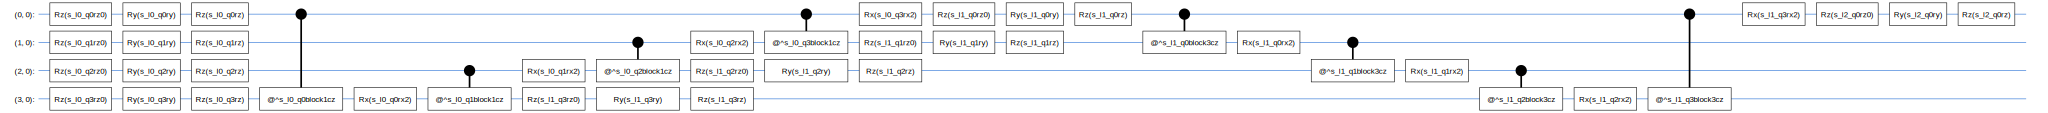

In [624]:
# TEST CELL to make sure CircuitLayerBuilder works properly
circuit = cirq.Circuit()
demo_builder = CircuitLayerBuilder(circuit=circuit,
                                   data_qubits = cirq.GridQubit.rect(4,1),)

#demo_builder.add_layer(block=1, apply_dropout=True)
demo_builder.add_layer(block=1, apply_dropout=False)
demo_builder.add_layer(block=3, apply_dropout=False) # Only apply dropout once
demo_builder.add_final_out()

SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [764]:
def create_quantum_model(apply_dropout=False, n_dropout=5, builder=None, computed_weights_arr=None):
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 2)  # a 4x2 grid.
    circuit = cirq.Circuit()
    
    if builder is None or computed_weights_arr is None:
        builder = CircuitLayerBuilder(
            circuit=circuit,
            data_qubits=data_qubits,
            repeat_dropout=n_dropout)
        if apply_dropout:
            builder.TEST_STATE_N_DROPOUT = n_dropout
            builder.TEST_STATE_DROPOUT_ID = np.random.randint(1, len(data_qubits) + 1)
        else:
            builder.TEST_STATE_N_DROPOUT = None
    else:
        builder.rebuild(circuit, data_qubits, computed_weights_arr, preserve_dropout=apply_dropout)
        
        if builder.TEST_STATE_N_DROPOUT is not None and builder.TEST_STATE_N_DROPOUT == 0:
            builder.TEST_STATE_N_DROPOUT = n_dropout
            builder.TEST_STATE_DROPOUT_ID = np.random.randint(1, len(data_qubits))
            if builder.TEST_STATE_DROPOUT_ID > len(data_qubits):
                builder.TEST_STATE_N_DROPOUT = 0 # retry on next!

    # Then add layers
    # only drop out one qubit as per Schuld
    builder.add_layer(block=1, apply_dropout=False)
    builder.add_layer(block=3, apply_dropout=False)
    builder.add_final_out()

    # Finally, prepare the readout qubit.

    #print('builder.TEST_STATE_N_DROPOUT = ', builder.TEST_STATE_N_DROPOUT)
    #print('builder.TEST_STATE_DROPOUT_ID = ', builder.TEST_STATE_DROPOUT_ID)
    if apply_dropout and builder.TEST_STATE_N_DROPOUT is not None and builder.TEST_STATE_DROPOUT_ID < len(data_qubits):
        print('Built model, going to drop out qubit id ', builder.TEST_STATE_DROPOUT_ID)
        readouts = [cirq.Z(data_qubits[0]), cirq.Z(data_qubits[builder.TEST_STATE_DROPOUT_ID])]
        builder.TEST_STATE_N_DROPOUT -= 1
    else:
        readouts = [cirq.Z(data_qubits[0]), cirq.Z(data_qubits[0])]
    
    return builder, circuit, readouts

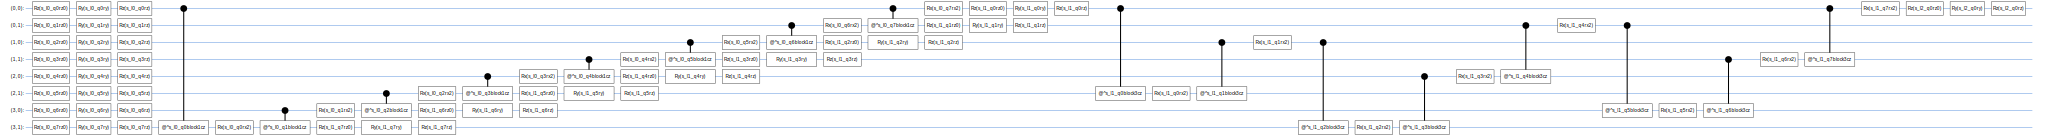

In [753]:
_, model_circuit, model_readouts = create_quantum_model(apply_dropout=False)
SVGCircuit(model_circuit)

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [668]:
# Build the Keras model.
qlayer = tfq.layers.PQC(model_circuit, model_readout)
print(len(qlayer.get_weights()[0]))

model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    qlayer,
])

83


Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [669]:
y_train_hinge = 2.0*y_train_nocon_256-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [670]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [671]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [672]:
print(model.summary())

Model: "sequential_486"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_488 (PQC)                (None, 1)                 83        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________
None


## 3. TensorBoard

In [673]:
logdir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [762]:
EPOCHS = 10
DROPOUT_EPOCHS = 2 # keep qubits dropped out for this num of epochs
#BATCH_SIZE = 32
BATCH_SIZE = None
#NUM_EXAMPLES=None

In [756]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [757]:
def train_model(apply_dropout=False):
    #dropout_backup_flag = False
    
    for i in range(EPOCHS):        
        # HACK - build new quantum circuit for each epoch and copy over the weights from the old one
        
        # Toggle apply_dropout off on first epoch
        #if dropout_backup_flag:
        #    apply_dropout = True
        #elif i == 0 and apply_dropout:
        #    apply_dropout = False
        #    dropout_backup_flag = True
        
        if i == EPOCHS-1:
            # Never use dropout on the last epoch; we can't get sane results otherwise
            # grab the epoch before last too for better results
            dropout_backup_flag = False
            apply_dropout = False
        
        if i == 0:
            model_builder, model_circuit, model_readouts = create_quantum_model(apply_dropout, DROPOUT_EPOCHS)
            qlayer = tfq.layers.PQC(model_circuit, model_readouts)
        else:
            model_builder, model_circuit, model_readouts = create_quantum_model(apply_dropout, DROPOUT_EPOCHS, model_builder, qlayer.get_weights()[0])
            qlayer_new = tfq.layers.PQC(model_circuit, model_readouts,
                                        initializer=tf.keras.initializers.Zeros)
            curr_l = model_builder.get_builder_weights()
            qlayer_new.set_weights([np.array(curr_l, dtype=np.float32)])
            qlayer = qlayer_new

        res_layer = tf.keras.layers.Lambda(lambda x: x[0])
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(), dtype=tf.string),
            qlayer,
            res_layer
        ])
        model.compile(
            loss=tf.keras.losses.Hinge(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[hinge_accuracy])

        print('Iteration ', i)
        # Now fit the model for this epoch
        model.fit(
              x_train_tfcirc_sub, y_train_hinge_sub,
              batch_size=1,
              epochs=1,
              verbose=1,
              callbacks=[tensorboard_callback])
        model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub, batch_size=1)
    
    return model

In [758]:
model = train_model(apply_dropout=False)

Iteration  0
500/500 [==============================] - 4s 9ms/step - loss: 0.8533 - hinge_accuracy: 0.8280
Iteration  1
500/500 [==============================] - 5s 9ms/step - loss: 0.7568 - hinge_accuracy: 0.8960
Iteration  2
500/500 [==============================] - 4s 9ms/step - loss: 0.7004 - hinge_accuracy: 0.9160
Iteration  3
500/500 [==============================] - 4s 8ms/step - loss: 0.6783 - hinge_accuracy: 0.9340
Iteration  4
500/500 [==============================] - 4s 9ms/step - loss: 0.6689 - hinge_accuracy: 0.9520
Iteration  5
500/500 [==============================] - 4s 8ms/step - loss: 0.6622 - hinge_accuracy: 0.9600
Iteration  6
500/500 [==============================] - 4s 9ms/step - loss: 0.6533 - hinge_accuracy: 0.9640
Iteration  7
500/500 [==============================] - 4s 9ms/step - loss: 0.6437 - hinge_accuracy: 0.9640
Iteration  8
500/500 [==============================] - 4s 9ms/step - loss: 0.6377 - hinge_accuracy: 0.9640
Iteration  9
500/500 [======

In [759]:
#print(y_train_hinge_sub)
#print(y_test)

#plt.imshow(x_train_nocon_256[3, :, :, 0])
#plt.colorbar()

print("Non-dropout training set perf:")
model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub, batch_size=1)
print("Non-dropout test set perf:")
qnn_results = model.evaluate(x_test_tfcirc, y_test_hinge, batch_size=1)

Non-dropout training set perf:
500/500 [==============================] - 4s 9ms/step - loss: 0.6349 - hinge_accuracy: 0.9640
Non-dropout test set perf:
1968/1968 [==============================] - 16s 8ms/step - loss: 0.6940 - hinge_accuracy: 0.9151


In [765]:
dropout_model = train_model(apply_dropout=True)

Built model, going to drop out qubit id  7
Iteration  0
500/500 [==============================] - 5s 9ms/step - loss: 0.9170 - hinge_accuracy: 0.7600
Built model, going to drop out qubit id  7
Iteration  1
500/500 [==============================] - 5s 9ms/step - loss: 0.8774 - hinge_accuracy: 0.7910
Built model, going to drop out qubit id  6
Iteration  2
500/500 [==============================] - 5s 9ms/step - loss: 0.8795 - hinge_accuracy: 0.7540
Built model, going to drop out qubit id  6
Iteration  3
500/500 [==============================] - 5s 9ms/step - loss: 0.8465 - hinge_accuracy: 0.7630
Built model, going to drop out qubit id  7
Iteration  4
500/500 [==============================] - 5s 9ms/step - loss: 0.8199 - hinge_accuracy: 0.7480
Built model, going to drop out qubit id  7
Iteration  5
500/500 [==============================] - 5s 9ms/step - loss: 0.7840 - hinge_accuracy: 0.7580
Built model, going to drop out qubit id  6
Iteration  6
500/500 [=============================

In [766]:
print("Dropout training set perf:")
dropout_model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub, batch_size=1)
print("Dropout test set perf:")
qnn_results = dropout_model.evaluate(x_test_tfcirc, y_test_hinge, batch_size=1)

Dropout training set perf:
500/500 [==============================] - 5s 9ms/step - loss: 0.6522 - hinge_accuracy: 0.9740
Dropout test set perf:
1968/1968 [==============================] - 17s 9ms/step - loss: 0.7298 - hinge_accuracy: 0.9527


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 4. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [158]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)             

In [159]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 1s 13ms/step - loss: 0.0057 - accuracy: 0.9990


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [160]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.fit(x_train_nocon_256,
          y_train_nocon_256,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
81/81 - 1s - loss: 0.6579 - accuracy: 0.5250 - val_loss: 0.6457 - val_accuracy: 0.4878
Epoch 2/20
81/81 - 0s - loss: 0.6325 - accuracy: 0.5525 - val_loss: 0.6172 - val_accuracy: 0.5701
Epoch 3/20
81/81 - 0s - loss: 0.5962 - accuracy: 0.6614 - val_loss: 0.5704 - val_accuracy: 0.7642
Epoch 4/20
81/81 - 0s - loss: 0.5455 - accuracy: 0.8182 - val_loss: 0.5161 - val_accuracy: 0.8237
Epoch 5/20
81/81 - 0s - loss: 0.4965 - accuracy: 0.8508 - val_loss: 0.4702 - val_accuracy: 0.8318
Epoch 6/20
81/81 - 0s - loss: 0.4564 - accuracy: 0.8564 - val_loss: 0.4347 - val_accuracy: 0.8308
Epoch 7/20
81/81 - 0s - loss: 0.4255 - accuracy: 0.8578 - val_loss: 0.4075 - val_accuracy: 0.8308
Epoch 8/20
81/81 - 0s - loss: 0.4008 - accuracy: 0.8582 - val_loss: 0.3854 - val_accuracy: 0.8323
Epoch 9/20
81/81 - 0s - loss: 0.3807 - accuracy: 0.8667 - val_loss: 0.3675 - val_accuracy: 0.8709
Epoch 10/20
81/81 - 0s - loss: 0.3637 - accuracy: 0.8803 - val_loss: 0.3522 - val_accuracy: 0.8709
Epoch 11/20
81/81 -

## 5. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

/Users/rickyyoung/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

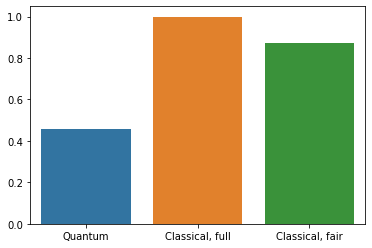

In [162]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])